In [1]:
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load your data
train_data_frame = pd.read_csv("dataset/clean_data/train_clean.csv")
test_data_frame = pd.read_csv("dataset/clean_data/test_clean.csv")

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

class CNNModel:
    def __init__(self, train_data, test_data, tokenizer_fn, sequence_length, opt, max_vocab=5000, batch_size=32):
        self.train_data = train_data
        self.test_data = test_data
        self.tokenizer_fn = tokenizer_fn
        self.max_vocab = max_vocab
        self.sequence_length = sequence_length
        self.optimizer = opt
        self.batch_size = batch_size

    def create_sequences(self, texts, is_training=False):
        if is_training:
            self.tokenizer = self.tokenizer_fn(num_words=self.max_vocab, oov_token='<OOV>')
            self.tokenizer.fit_on_texts(texts)
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded_sequences = np.array(pad_sequences(sequences, maxlen=self.sequence_length, padding='post', truncating='post'))
        return padded_sequences

    def train_model(self, model_category, epochs=10, use_raw_text=False):
        tf.random.set_seed(42)

        model_architectures = {
            'xs': (128, 32, 0.3),  # Increased embedding dimension and filters for more feature extraction
            's': (128, 64, 0.3),
            'm': (256, 128, 0.3),
            'l': (300, 256, 0.3)
        }

        if model_category not in model_architectures:
            print("Please enter a valid model type: xs/s/m/l")
            return

        embedding_dim, num_filters, dropout_rate = model_architectures[model_category]

        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.max_vocab, output_dim=embedding_dim, input_length=self.sequence_length),
            tf.keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(filters=num_filters * 2, kernel_size=3, activation='relu'),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(num_filters, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.is_raw_text = use_raw_text

        if use_raw_text:
            train_sequences = self.create_sequences(self.train_data['review_content'].tolist(), is_training=True)
        else:
            train_sequences = self.create_sequences(self.train_data['clean_text'].tolist(), is_training=True)

        y_train = np.array(self.train_data['sentiment'].map({'pos': 1, 'neg': 0}).tolist())
        
        # Shuffle data
        combined_data = list(zip(train_sequences, y_train))
        np.random.seed(12)
        np.random.shuffle(combined_data)
        train_sequences, y_train = zip(*combined_data)

        train_sequences = np.array(train_sequences)
        y_train = np.array(y_train)

        # Split data
        num_validation_samples = int(0.20 * len(train_sequences))
        x_train = train_sequences[:-num_validation_samples]
        y_train_split = y_train[:-num_validation_samples]
        x_val = train_sequences[-num_validation_samples:]
        y_val = y_train[-num_validation_samples:]

        # Increased patience for early stopping
        early_stopping_acc = EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, restore_best_weights=True)
        early_stopping_loss = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)

        # Compile with a lower learning rate for better convergence
        model.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Reduced learning rate
                      metrics=['accuracy'])

        history = model.fit(x_train, y_train_split, epochs=epochs, batch_size=self.batch_size, 
                            validation_data=(x_val, y_val), shuffle=True,  # Enable shuffling
                            callbacks=[early_stopping_acc, early_stopping_loss])

        if early_stopping_acc.stopped_epoch > 0:
            print(f'Early stopping occurred at epoch {early_stopping_acc.stopped_epoch + 1} (validation accuracy).')
        if early_stopping_loss.stopped_epoch > 0:
            print(f'Early stopping occurred at epoch {early_stopping_loss.stopped_epoch + 1} (validation loss).')

        self.model = model
        self.train_accuracy = history.history['accuracy']
        self.val_accuracy = history.history['val_accuracy']
        self.train_loss = history.history['loss']
        self.val_loss = history.history['val_loss']

        # Ensure the save directory exists
        save_dir = 'data/CNN_models'
        os.makedirs(save_dir, exist_ok=True)
        model_save_path = os.path.join(save_dir, f'model_type_{model_category}_epochs_{epochs}_{self.max_vocab}_{self.sequence_length}_adam_{use_raw_text}.keras')
        
        model.save(model_save_path)

    def evaluate_model(self):
        if self.is_raw_text:
            test_sequences = self.create_sequences(self.test_data['review_content'].tolist(), is_training=False)
        else:
            test_sequences = self.create_sequences(self.test_data['clean_text'].tolist(), is_training=False)

        y_test = np.array(self.test_data['sentiment'].map({'pos': 1, 'neg': 0}).tolist())
        predictions = self.model.predict(test_sequences)
        binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

        accuracy = accuracy_score(y_test, binary_predictions)
        print("Accuracy (CNN):", accuracy)

        confusion_matrix_result = confusion_matrix(y_test, binary_predictions)
        print("Confusion Matrix (CNN):\n", confusion_matrix_result)

        classification_report_result = classification_report(y_test, binary_predictions)
        print("Classification Report (CNN):\n", classification_report_result)


In [4]:
# Training and evaluation functions
def train_cnn(num_words, max_length, learning_rate, batch_size, model_size, epoch, bool):
    cnn_trainer = CNNModel(
        train_data=train_data_frame,
        test_data=test_data_frame,
        tokenizer_fn=Tokenizer,
        sequence_length=max_length,
        opt=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        max_vocab=num_words,
        batch_size=batch_size
    )
    
    cnn_trainer.train_model(model_size, epoch, bool)
    cnn_trainer.model.summary()
    cnn_trainer.evaluate_model()

    return cnn_trainer

In [5]:
def plot_accuracy(trainer):
    epoch_range = range(1, len(trainer.train_accuracy) + 1)
    plt.plot(epoch_range, trainer.train_accuracy, color='blue', label='Training Accuracy')
    plt.plot(epoch_range, trainer.val_accuracy, color='red', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [6]:
def plot_loss(trainer):
    epoch_range = range(1, len(trainer.train_loss) + 1)
    plt.plot(epoch_range, trainer.train_loss, color='blue', label='Training Loss')
    plt.plot(epoch_range, trainer.val_loss, color='red', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 808ms/step - accuracy: 0.5346 - loss: 0.6942 - val_accuracy: 0.5046 - val_loss: 0.6900
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 785ms/step - accuracy: 0.6964 - loss: 0.5977 - val_accuracy: 0.6058 - val_loss: 0.6821
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 787ms/step - accuracy: 0.7759 - loss: 0.4969 - val_accuracy: 0.7364 - val_loss: 0.6671
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 778ms/step - accuracy: 0.8245 - loss: 0.4150 - val_accuracy: 0.7836 - val_loss: 0.6503
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 761ms/step - accuracy: 0.8563 - loss: 0.3535 - val_accuracy: 0.7980 - val_loss: 0.6300
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 769ms/step - accuracy: 0.8849 - loss: 0.3012 - val_accuracy: 0.7980 - val_loss: 0.6087
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 781ms/step - accuracy: 0.9081 - loss: 0.2594 - val_accuracy: 0.8074 - val_loss: 0.5841
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 758ms/step - accuracy: 0.9278 - loss: 0.2225 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 150, 256)            │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 148, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 74, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 72, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,075,077 (4.10 MB)

 Trainable params: 358,273 (1.37 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 716,548 (2.73 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step
Accuracy (CNN): 0.81068
Confusion Matrix (CNN):
 [[ 9787  2713]
 [ 2020 10480]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.83      0.78      0.81     12500
           1       0.79      0.84      0.82     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



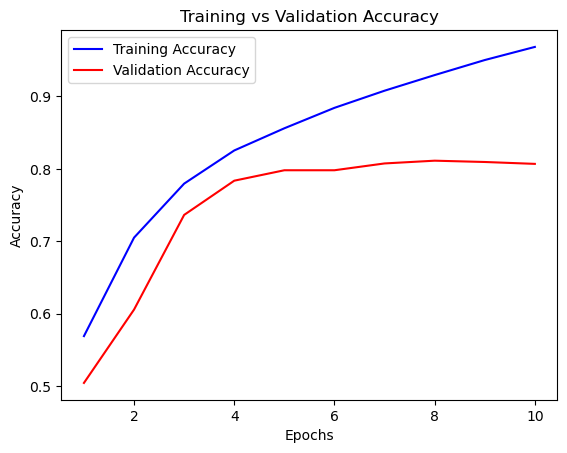

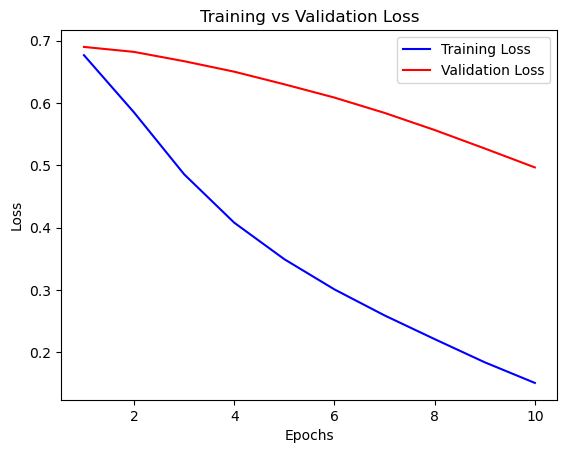

In [7]:
# Example run
num_words = 500
max_len = 150
learning_rate = 0.003
epochs = 10
batch_size = 512
model_size = 'm'
bool = False

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.5094 - loss: 0.7047 - val_accuracy: 0.5948 - val_loss: 0.6917
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.6319 - loss: 0.6510 - val_accuracy: 0.5856 - val_loss: 0.6890
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.6962 - loss: 0.6019 - val_accuracy: 0.6902 - val_loss: 0.6812
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.7552 - loss: 0.5297 - val_accuracy: 0.7524 - val_loss: 0.6686
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.7919 - loss: 0.4691 - val_accuracy: 0.7758 - val_loss: 0.6519
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.8266 - loss: 0.4119 - val_accuracy: 0.7992 - val_loss: 0.6281
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.8524 - loss: 0.3648 - val_accuracy: 0.8098 - val_loss: 0.6017
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.8709 - loss: 0.3274 - val

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 150, 128)            │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 148, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 74, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 72, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 461,509 (1.76 MB)

 Trainable params: 153,793 (600.75 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 307,588 (1.17 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step
Accuracy (CNN): 0.8162
Confusion Matrix (CNN):
 [[10057  2443]
 [ 2152 10348]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81     12500
           1       0.81      0.83      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



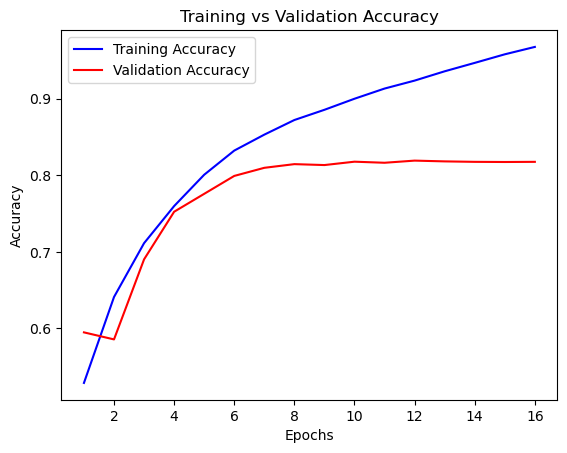

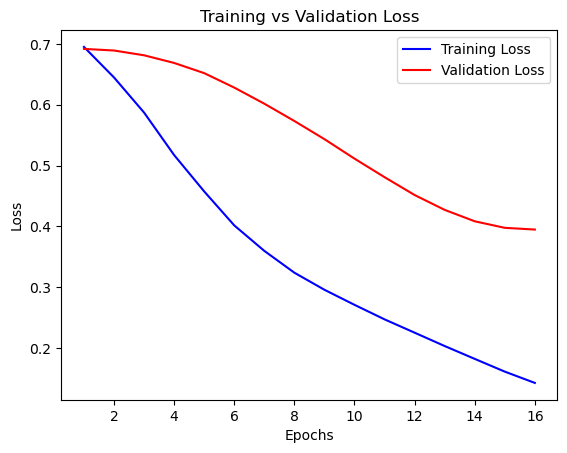

In [8]:
num_words = 750
max_len = 150
learning_rate = 0.003
epochs = 100
batch_size = 512
model_size='s'
bool = False

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.5259 - loss: 0.6938 - val_accuracy: 0.4990 - val_loss: 0.6922
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.6308 - loss: 0.6531 - val_accuracy: 0.4990 - val_loss: 0.6902
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.7040 - loss: 0.6032 - val_accuracy: 0.5006 - val_loss: 0.6833
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.7558 - loss: 0.5337 - val_accuracy: 0.5166 - val_loss: 0.6738
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.7939 - loss: 0.4819 - val_accuracy: 0.5728 - val_loss: 0.6594
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.8294 - loss: 0.4214 - val_accuracy: 0.6244 - val_loss: 0.6385
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.8559 - loss: 0.3689 - val_accuracy: 0.7080 - val_loss: 0.6102
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.8765 - loss: 0.3257 - val_a

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 150, 128)            │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 148, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 74, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 72, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 557,509 (2.13 MB)

 Trainable params: 185,793 (725.75 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 371,588 (1.42 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step
Accuracy (CNN): 0.82484
Confusion Matrix (CNN):
 [[10330  2170]
 [ 2209 10291]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.82      0.83      0.83     12500
           1       0.83      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



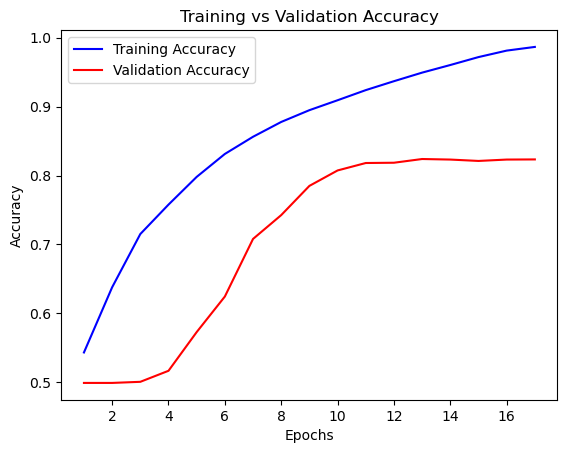

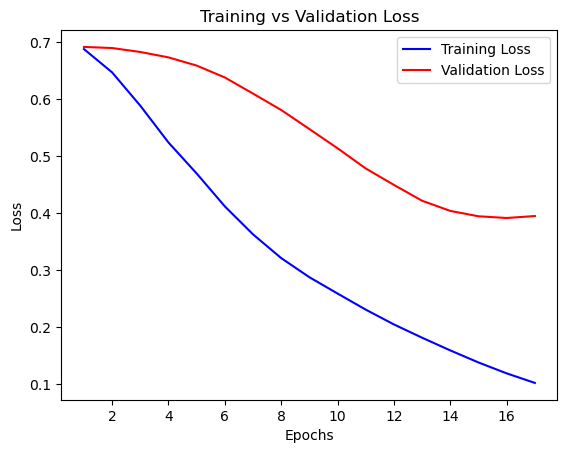

In [9]:
num_words = 1000
max_len = 150
learning_rate = 0.003
epochs = 100
batch_size = 512
model_size='s'
bool = False

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 810ms/step - accuracy: 0.5393 - loss: 0.6906 - val_accuracy: 0.5016 - val_loss: 0.6909
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 766ms/step - accuracy: 0.7123 - loss: 0.5973 - val_accuracy: 0.5082 - val_loss: 0.6846
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 773ms/step - accuracy: 0.8025 - loss: 0.4857 - val_accuracy: 0.5462 - val_loss: 0.6698
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 771ms/step - accuracy: 0.8585 - loss: 0.3793 - val_accuracy: 0.6920 - val_loss: 0.6491
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 772ms/step - accuracy: 0.9035 - loss: 0.2914 - val_accuracy: 0.7150 - val_loss: 0.6268
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 783ms/step - accuracy: 0.9402 - loss: 0.2213 - val_accuracy: 0.7762 - val_loss: 0.5994
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 814ms/step - accuracy: 0.9655 - loss: 0.1652 - val_accuracy: 0.8116 - val_loss: 0.5679
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 771ms/step - accuracy: 0.9840 - loss: 0.1213 - 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 150, 256)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 148, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 74, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 72, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,611,077 (9.96 MB)

 Trainable params: 870,273 (3.32 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,740,548 (6.64 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step
Accuracy (CNN): 0.83728
Confusion Matrix (CNN):
 [[10336  2164]
 [ 1904 10596]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.84      0.83      0.84     12500
           1       0.83      0.85      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



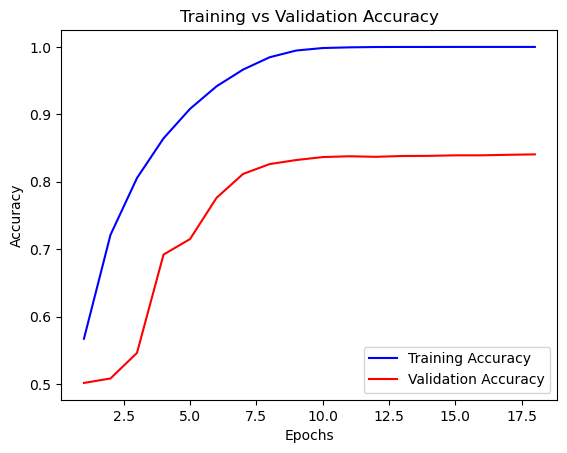

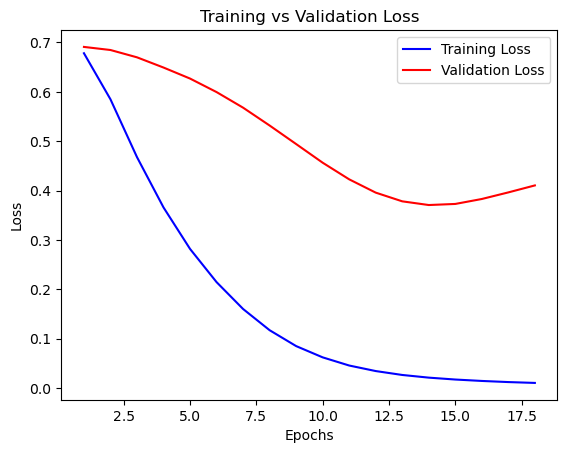

In [10]:
num_words = 2500
max_len = 150
learning_rate = 0.003
epochs = 100
batch_size = 512
model_size='m'
bool = False

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 799ms/step - accuracy: 0.5458 - loss: 0.6887 - val_accuracy: 0.5014 - val_loss: 0.6906
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 789ms/step - accuracy: 0.7529 - loss: 0.5708 - val_accuracy: 0.5112 - val_loss: 0.6823
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 783ms/step - accuracy: 0.8415 - loss: 0.4350 - val_accuracy: 0.6110 - val_loss: 0.6664
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 789ms/step - accuracy: 0.9052 - loss: 0.3166 - val_accuracy: 0.6716 - val_loss: 0.6462
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 759ms/step - accuracy: 0.9440 - loss: 0.2222 - val_accuracy: 0.7632 - val_loss: 0.6203
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 788ms/step - accuracy: 0.9735 - loss: 0.1515 - val_accuracy: 0.8126 - val_loss: 0.5909
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 788ms/step - accuracy: 0.9912 - loss: 0.1018 - val_accuracy: 0.8422 - val_loss: 0.5565
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 782ms/step - accuracy: 0.9973 - loss: 0.0682 - 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 150, 256)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 148, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 74, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 72, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,531,077 (17.28 MB)

 Trainable params: 1,510,273 (5.76 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 3,020,548 (11.52 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step
Accuracy (CNN): 0.83296
Confusion Matrix (CNN):
 [[ 9873  2627]
 [ 1549 10951]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.86      0.79      0.83     12500
           1       0.81      0.88      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



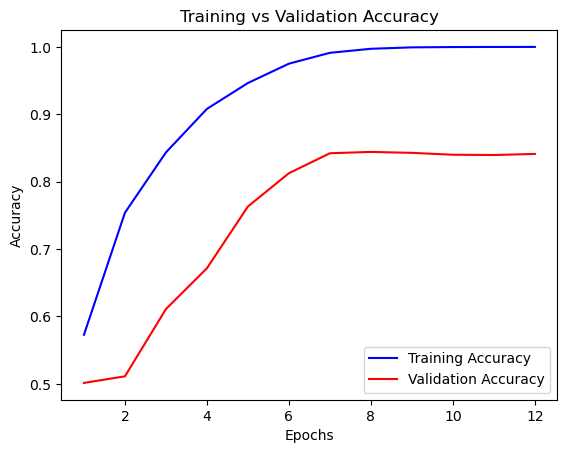

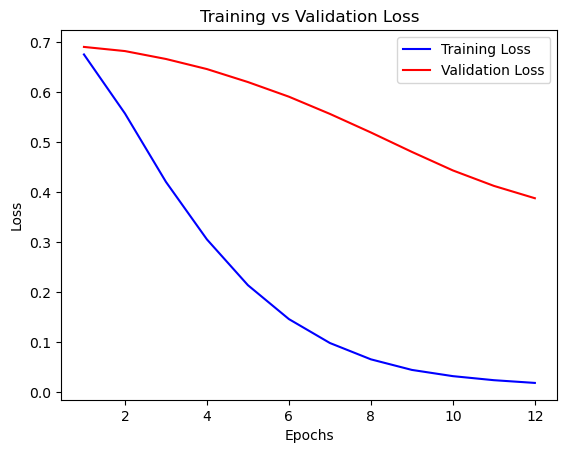

In [11]:
num_words = 5000
max_len = 150
learning_rate = 0.003
epochs = 100
batch_size = 512
model_size='m'
bool = False

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 571ms/step - accuracy: 0.5423 - loss: 0.6899 - val_accuracy: 0.4990 - val_loss: 0.6908
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 553ms/step - accuracy: 0.7799 - loss: 0.5477 - val_accuracy: 0.4994 - val_loss: 0.6828
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 537ms/step - accuracy: 0.8414 - loss: 0.4220 - val_accuracy: 0.5072 - val_loss: 0.6717
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 548ms/step - accuracy: 0.9119 - loss: 0.3083 - val_accuracy: 0.5426 - val_loss: 0.6539
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 325ms/step - accuracy: 0.9493 - loss: 0.2139 - val_accuracy: 0.6104 - val_loss: 0.6320
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 361ms/step - accuracy: 0.9770 - loss: 0.1430 - val_accuracy: 0.6848 - val_loss: 0.6050
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 326ms/step - accuracy: 0.9923 - loss: 0.0931 - val_accuracy: 0.7626 - val_loss: 0.5716
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 377ms/step - accuracy: 0.9982 - loss: 0.0612 - 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 256)            │       1,920,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 98, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 49, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 47, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,451,077 (24.61 MB)

 Trainable params: 2,150,273 (8.20 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 4,300,548 (16.41 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
Accuracy (CNN): 0.8196
Confusion Matrix (CNN):
 [[10131  2369]
 [ 2141 10359]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.83      0.81      0.82     12500
           1       0.81      0.83      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



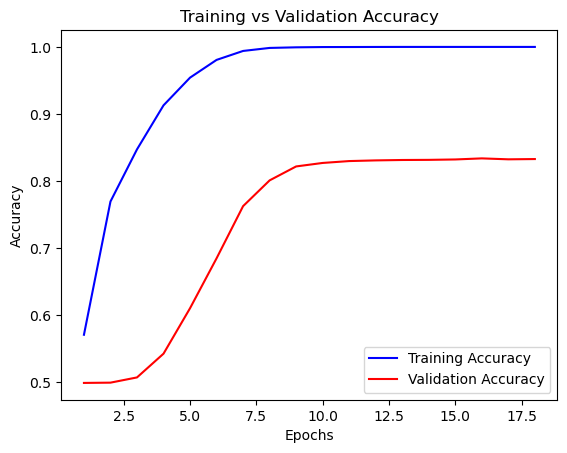

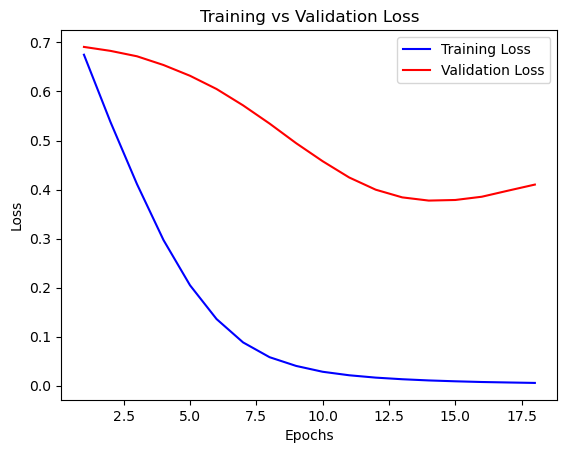

In [12]:
num_words = 7500
max_len = 100
learning_rate = 0.003
epochs = 100
batch_size = 512
model_size='m'
bool = False

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - accuracy: 0.5146 - loss: 0.7016 - val_accuracy: 0.5266 - val_loss: 0.6917
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - accuracy: 0.7030 - loss: 0.6081 - val_accuracy: 0.6148 - val_loss: 0.6887
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 370ms/step - accuracy: 0.8017 - loss: 0.5181 - val_accuracy: 0.6642 - val_loss: 0.6824
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - accuracy: 0.8859 - loss: 0.4036 - val_accuracy: 0.7012 - val_loss: 0.6705
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.9334 - loss: 0.2951 - val_accuracy: 0.7390 - val_loss: 0.6550
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 338ms/step - accuracy: 0.9707 - loss: 0.2011 - val_accuracy: 0.7488 - val_loss: 0.6367
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step - accuracy: 0.9926 - loss: 0.1317 - val_accuracy: 0.7568 - val_loss: 0.6144
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step - accuracy: 0.9982 - loss: 0.0841 - val_accu

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 256)            │       1,920,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 98, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 49, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 47, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_6               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,451,077 (24.61 MB)

 Trainable params: 2,150,273 (8.20 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 4,300,548 (16.41 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Accuracy (CNN): 0.76276
Confusion Matrix (CNN):
 [[9422 3078]
 [2853 9647]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.77      0.75      0.76     12500
           1       0.76      0.77      0.76     12500

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000



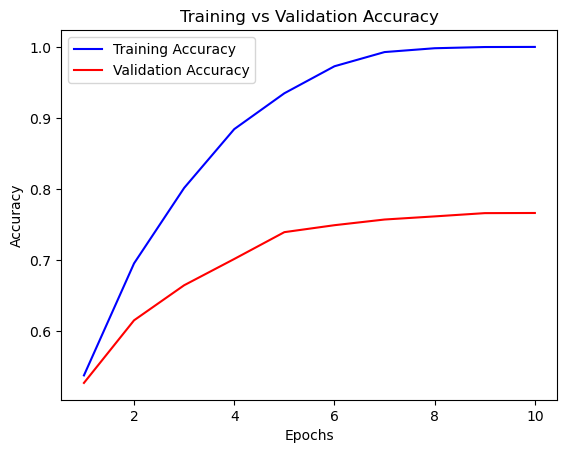

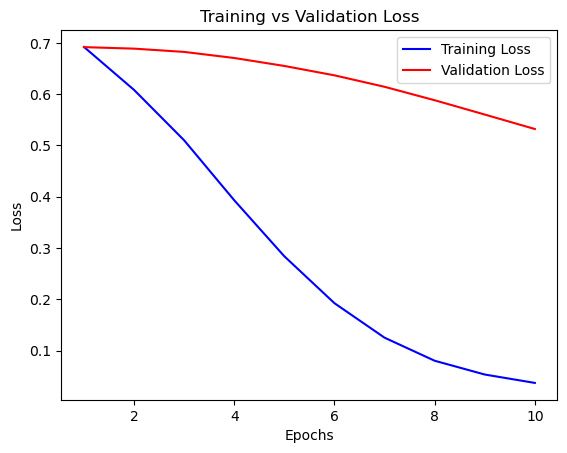

In [13]:
num_words = 7500
max_len = 100
learning_rate = 0.003
epochs = 10
batch_size = 512
model_size='m'
bool = True

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5571 - loss: 0.6823 - val_accuracy: 0.5364 - val_loss: 0.6880
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8260 - loss: 0.4838 - val_accuracy: 0.5780 - val_loss: 0.6723
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9017 - loss: 0.3095 - val_accuracy: 0.6428 - val_loss: 0.6526
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9657 - loss: 0.1727 - val_accuracy: 0.6854 - val_loss: 0.6284
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9929 - loss: 0.0864 - val_accuracy: 0.7646 - val_loss: 0.5971
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9989 - loss: 0.0427 - val_accuracy: 0.8154 - val_loss: 0.5590
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9999 - loss: 0.0234 - val_accuracy: 0.8426 - val_loss: 0.5183
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9999 - loss: 0.0145 - val_accuracy: 0.8456 - val_loss:

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 150, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 148, 256)            │         230,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 74, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 72, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_7               │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,269,957 (42.99 MB)

 Trainable params: 3,756,481 (14.33 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 7,512,964 (28.66 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step
Accuracy (CNN): 0.83644
Confusion Matrix (CNN):
 [[10389  2111]
 [ 1978 10522]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.84      0.83      0.84     12500
           1       0.83      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



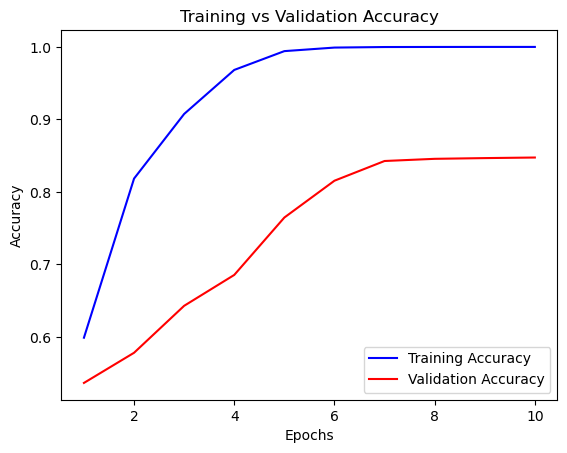

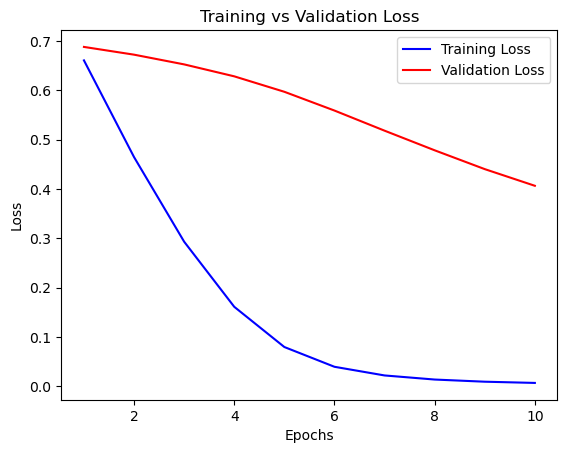

In [14]:
num_words = 10000
max_len = 150
learning_rate = 0.003
epochs = 10
batch_size = 512
model_size='l'
bool = False

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5414 - loss: 0.6876 - val_accuracy: 0.5036 - val_loss: 0.6905
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7992 - loss: 0.5380 - val_accuracy: 0.5264 - val_loss: 0.6840
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8972 - loss: 0.3854 - val_accuracy: 0.5548 - val_loss: 0.6696
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9591 - loss: 0.2267 - val_accuracy: 0.6428 - val_loss: 0.6497
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9920 - loss: 0.1158 - val_accuracy: 0.7232 - val_loss: 0.6253
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9994 - loss: 0.0585 - val_accuracy: 0.7774 - val_loss: 0.5962
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 1.0000 - loss: 0.0323 - val_accuracy: 0.7948 - val_loss: 0.5649
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 1.0000 - loss: 0.0203 - val_accuracy: 0.8070 - val_loss:

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 150, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 148, 256)            │         230,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 74, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 72, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_8               │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,269,957 (42.99 MB)

 Trainable params: 3,756,481 (14.33 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 7,512,964 (28.66 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step
Accuracy (CNN): 0.80656
Confusion Matrix (CNN):
 [[10309  2191]
 [ 2645  9855]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.80      0.82      0.81     12500
           1       0.82      0.79      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



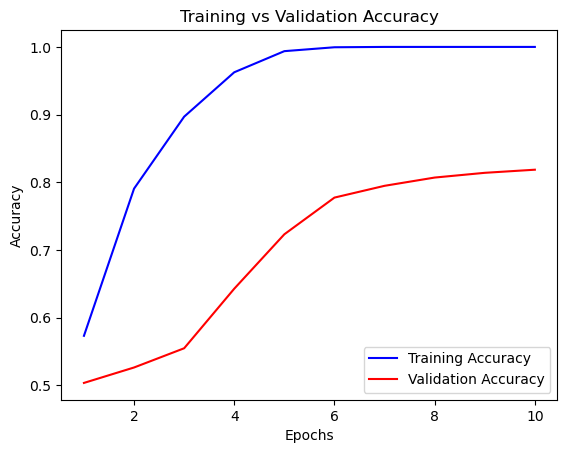

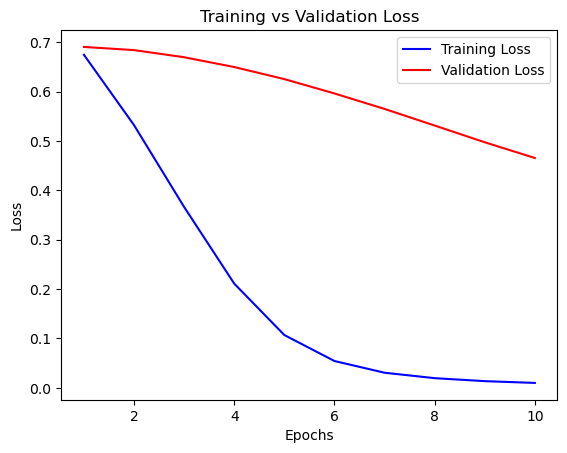

In [15]:
num_words = 10000
max_len = 150
learning_rate = 0.003
epochs = 10
batch_size = 512
model_size='l'
bool = True

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 61s 707ms/step - accuracy: 0.5748 - loss: 0.6664 - val_accuracy: 0.6050 - val_loss: 0.6783
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 60s 765ms/step - accuracy: 0.8593 - loss: 0.3884 - val_accuracy: 0.7858 - val_loss: 0.6440
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 60s 757ms/step - accuracy: 0.9651 - loss: 0.1684 - val_accuracy: 0.8042 - val_loss: 0.5931
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 60s 757ms/step - accuracy: 0.9971 - loss: 0.0542 - val_accuracy: 0.8312 - val_loss: 0.5225
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 60s 756ms/step - accuracy: 0.9999 - loss: 0.0200 - val_accuracy: 0.8358 - val_loss: 0.4462
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 64s 807ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.8362 - val_loss: 0.3884
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 59s 752ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.8374 - val_loss: 0.3576
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 59s 751ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accu

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 150, 300)            │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 148, 256)            │         230,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 74, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 72, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_9               │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,269,957 (77.32 MB)

 Trainable params: 6,756,481 (25.77 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 13,512,964 (51.55 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step
Accuracy (CNN): 0.83136
Confusion Matrix (CNN):
 [[10347  2153]
 [ 2063 10437]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.83      0.83      0.83     12500
           1       0.83      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



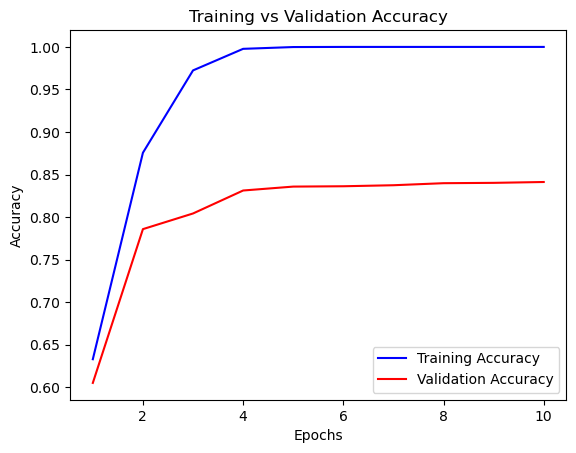

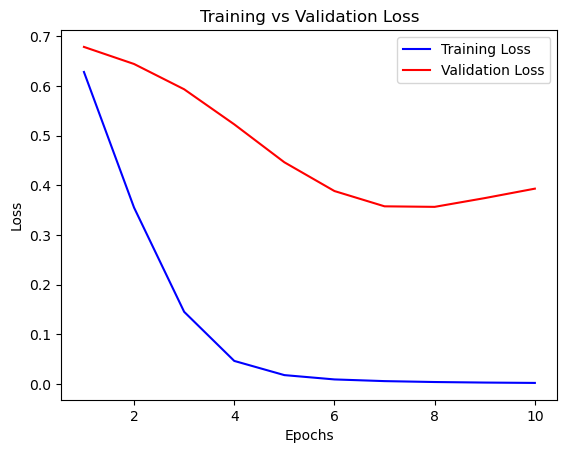

In [16]:
num_words = 20000
max_len = 150
learning_rate = 0.003
epochs = 10
batch_size = 256
model_size='l'
bool = False

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 62s 737ms/step - accuracy: 0.5399 - loss: 0.6887 - val_accuracy: 0.6614 - val_loss: 0.6885
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 80s 704ms/step - accuracy: 0.8344 - loss: 0.4975 - val_accuracy: 0.7668 - val_loss: 0.6641
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 61s 773ms/step - accuracy: 0.9458 - loss: 0.2477 - val_accuracy: 0.8000 - val_loss: 0.6206
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 840ms/step - accuracy: 0.9945 - loss: 0.0825 - val_accuracy: 0.8038 - val_loss: 0.5602
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9999 - loss: 0.0267 - val_accuracy: 0.8152 - val_loss: 0.4920
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 64s 815ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 0.8172 - val_loss: 0.4346
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 68s 858ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.8206 - val_loss: 0.4027
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 150, 300)            │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 148, 256)            │         230,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 74, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 72, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_10              │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,269,957 (77.32 MB)

 Trainable params: 6,756,481 (25.77 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 13,512,964 (51.55 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step
Accuracy (CNN): 0.80452
Confusion Matrix (CNN):
 [[10256  2244]
 [ 2643  9857]]
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.80      0.82      0.81     12500
           1       0.81      0.79      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



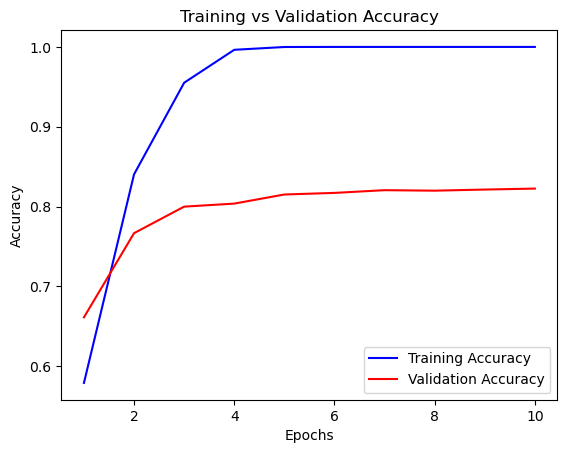

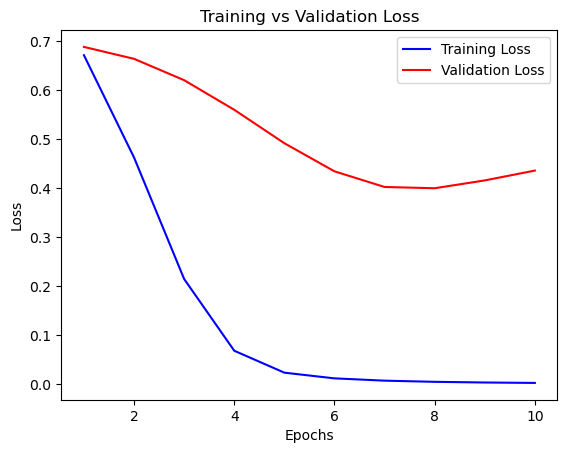

In [17]:
num_words = 20000
max_len = 150
learning_rate = 0.003
epochs = 10
batch_size = 256
model_size='l'
bool = True

trained_cnn_model = train_cnn(num_words, max_len, learning_rate, batch_size, model_size, epochs, bool)
plot_accuracy(trained_cnn_model)
plot_loss(trained_cnn_model)